# The Effect of Tweets on Stock Price Movements
The goal of our project is to find whether tweets by a company's official account affect its stock price. In a separate file, we used the tweet sentiment as the only feature (X) and classified daily stock price movements into class 1 (up) or class 0 (down). However, it ended up with low accuracy scores around 50%. <br>
In this file, starting from the assumption that the most important feature is the previous stock price, we examine whether the tweet sentiment improves the performance of models based on stock prices in the past. In specific, we compare the peformance of a model based on only a moving average of stock prices with that of another model using both the moving average and the tweet sentiment as feature values.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

import hvplot.pandas
import matplotlib.pyplot as plt

from collections import Counter
import panel as pn
pn.extension('plotly')
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# To avoid overfitting, stop processing if score doesn't change for a specified epochs
from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='loss', patience=30)


Bad key "text.kerning_factor" on line 4 in
C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kn_na\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# I. Sentiment Analysis for Tweets

Using Twint, fetch all Tweets by the official accounts of Microsoft, Sony, Pfizer, Regeneron, and Moderna. Then, conduct the sentiment analysis for each Tweet, and calculate the average compound score for each day.

In [2]:
# function to read and clean tweet data obtained by Twint
def read_file(ticker):
    
    # read data
    file_path = Path('companies_tweet_data_10y/' + ticker + '.csv')
    tweet_df = pd.read_csv(file_path, 
                           parse_dates=[['date','time']], 
                           infer_datetime_format=True, 
                           usecols=['tweet','date','time','retweets_count','likes_count']
                          )
    
    # clean up index
    tweet_df.set_index('date_time', inplace=True)
    tweet_df.index.name = None
    tweet_df.sort_index(axis=0, inplace=True)
    
    # extract tweets before the market closing time (4 pm)
    tweet_df = tweet_df.between_time('00:00:00','15:59:00', include_end=False)
    
    # delete time in index to concatenate df with a stock price df later
    tweet_df.index = tweet_df.index.date
    
    # assume the more a tweet is retweeted or liked, the more it would has an impact on stock prices
    # to find some correlation b/w tweets and stock prices more clearly, exclude unimportant tweets
    tweet_df = tweet_df[(tweet_df['retweets_count']>=tweet_df['retweets_count'].mean())\
                        | (tweet_df['likes_count']>=tweet_df['likes_count'].mean())]
    
    return tweet_df

In [3]:
# function to run a sentiment analysis
def sentiment_analysis(tweet_df):
    
    # list to hold sentiment scores
    tweet_sentiments = []
    
    # run a sentiment analysis for each tweet
    for tweet in tweet_df["tweet"]:
        try:
            sentiment = analyzer.polarity_scores(tweet)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
            
            # save sentiment scores in the list
            tweet_sentiments.append({"compound": compound,
                                     "positive": pos,
                                     "negative": neg,
                                     "neutral": neu
                                    })
        
        except AttributeError:
            pass
    
    # Create DataFrame of the sentiment scores
    sentiments_df = pd.DataFrame(tweet_sentiments, index=tweet_df.index)
    
    # Combine the sentiment scores with the tweet df
    df = tweet_df.join(sentiments_df)
    
    # calculate average compound scores for each day
    sentiment_score_df = df.groupby(level=0)[['compound']].mean()
    sentiment_score_df = sentiment_score_df.rename(columns={'compound':'sentiment'})
    
    return sentiment_score_df

# II. Calculate Moving Average and Add Signals

In [4]:
# function to get stock price data from Alpaca API
def stock_prices(ticker):
    
    # read API Keys
    load_dotenv()
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

    # Create the Alpaca API object
    api = tradeapi.REST(alpaca_api_key,
                        alpaca_secret_key,
                        api_version = "v2"
                       )
    
    start_date = pd.Timestamp("2015-01-15", tz="America/New_York").isoformat()
    end_date = pd.Timestamp("2021-01-15", tz="America/New_York").isoformat()
    tickers = ["MSFT", "SNE", "PFE", "REGN", "MRNA"]
    timeframe = "1D"

    stock_tickers = api.get_barset(tickers,
                                   timeframe,
                                   start=start_date,
                                   end=end_date
                                  ).df
    
    # extract only close prices
    stock_tickerspx = pd.DataFrame()
    stock_tickerspx["MSFT"] = stock_tickers["MSFT"]["close"]
    stock_tickerspx["SNE"] = stock_tickers["SNE"]["close"]
    stock_tickerspx["PFE"] = stock_tickers["PFE"]["close"]
    stock_tickerspx["REGN"] = stock_tickers["REGN"]["close"]
    stock_tickerspx["MRNA"] = stock_tickers["MRNA"]["close"]
    
    stock_tickerspx = stock_tickerspx[[ticker]]
    
    # Drop the time component of the date
    stock_tickerspx.index = stock_tickers.index.date
    index = stock_tickerspx.index
    index.name = "Date"
    stock_tickerspx.reset_index(level=0, inplace=True)
    stock_tickerspx.set_index(pd.to_datetime(stock_tickerspx['Date'], 
                                             infer_datetime_format=True), 
                              inplace=True, 
                              drop=True
                             )
    stock_tickerspx.drop(columns=['Date'], inplace=True)

    return stock_tickerspx

In [5]:
# function to add the 20-day moving average and trading signals
def add_sma_signal(df, ticker):
    
    # calculate moving average
    df["SMA20"] = df[ticker].rolling(window=20).mean()
    
    # to use SMA to predict the close price / signal on the following day, shift the column by 1
    df["SMA_shift"] = df['SMA20'].shift()
    
    # calculate daily returns and drop NaN on the first row
    df['daily_return'] = df[ticker].pct_change()
    df.dropna(inplace=True, subset=['daily_return'])
    
    # add signals for the classification analysis purpose
    df['signal'] = np.where(df['daily_return']>0, 1.0, 0.0)
    
    return df

In [6]:
# function to combine the sentiment df and the stock price df
def combine_dataframe(df1, df2, ticker):
    
    df3 = df1.join([df2])
    
    # drop NaN values
    # there are days when a company official account doesn't tweet, and the sentiments of those days are NaN
    # to make the number of samples equal b/w the 1 feature dataset and the 2 features dataset,
    # drop days without a sentiment score
    df3.dropna(inplace=True, subset=['sentiment','SMA_shift'])
    
    return df3

# III. Train/Test Data Creation
To compare performance of a model using close prices as the only X feature with performance of a model using close prices and sentiment scores as X features, create two patterns of X datasets. Further, to run both regression and classification analyses, create two patterns of y values for each of the two X datasets. In total, create four datasets.

## 1. Create Data for Regression based on 1 Feature

In [7]:
# create a dataset which has moving average as the only X feature and close price as y value
def create_dataset_for_1feature_regression(df, ticker):
    
    # take the moving average as X and close prices as y
    # reshape the data to apply models later
    X = df[['SMA_shift']].values.reshape(-1,1)
    y = df[[ticker]].values.reshape(-1,1)
    
    # split into train data and test data
    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [8]:
# function to scale train data and test data 
def scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test):
    
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    return X, X_train, X_test, y, y_train, y_test

## 2. Create Data for Regression based on 2 features

In [9]:
# create a dataset which has moving average and sentiment scores as X features and close price as y value
def create_dataset_for_2features_regression(df, ticker):
    
    # take the moving average and sentiment scores as X and close prices as y
    X = df[['SMA_shift','sentiment']]
    y = df[[ticker]]
    
    # split into train data and test data
    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [10]:
# function to scale train data and test data
def scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test):
    
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)
    
    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(np.array(y).reshape(-1, 1))

    # Scale the target training and testing sets
    y_train = scaler.transform(np.array(y_train).reshape(-1, 1))
    y_test = scaler.transform(np.array(y_test).reshape(-1, 1))
    
    return X, X_train, X_test, y, y_train, y_test

## 3. Create Data for Classification based on 1 feature

In [11]:
# create a dataset which has moving average as the only X feature and trading signals as y value
def create_dataset_for_1feature_classification(df, ticker):
    
    # take the moving average as X and trading signals as y
    # reshape the data to apply models later
    X = df[['SMA_shift']].values.reshape(-1,1)
    y = df[['signal']].values.reshape(-1,1)
    
    # split into train data and test data
    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [12]:
# function to scale train data and test data
# y value need not be scaled in classification
def scaler_for_1feature_classification_data(X, X_train, X_test):
    
    # Create a MinMaxScaler object 
    scaler = MinMaxScaler()
    
    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)
    
    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, X_train, X_test

## 4. Create Data for Classification based on 2 Features

In [13]:
# create a dataset which has moving average and sentiment scores as X features and trading signals as y value
def create_dataset_for_2features_classification(df, ticker):
    
    # take the moving average and sentiment scores as X and trading signals as y
    X=df[['SMA_shift','sentiment']].values.reshape(-1,2)
    y=df[['signal']].values.reshape(-1,1)
    
    # split into train data and test data
    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [14]:
# function to scale train data and test data
# y value need not be scaled in classification
def scaler_for_2features_classification_data(X, X_train, X_test):
    
    # Create a MinMaxScaler object 
    scaler = MinMaxScaler()
    
    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)
    
    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, X_train, X_test

# IV. Functions of Models
To compare the 1-feature model and the 2-features model in both regression and classification analyses, define those models. Here, in regression analysis, examine the datasets created above with the two types of model: (i) a basic Dense Neural Network model and (ii) an LSTM model. In classification analysis, in addition to those 2 models, apply 5 Sklearn models.

## 1. Functions for Regression

### (a) Dense based on 1 feature

In [15]:
# nn comprising only dense layers to run regression analysis
def regression_dense_1feature(X_train, y_train):
    
    # Create a sequential model
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(1,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae']
                 )
    
    # Fit the model
    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=300, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [16]:
# function to hold the scores of learning in a df
# use the df later to visualize the difference in scores b\w the 1-feature model and the 2-features model
def score_regression_dense_1feature(history):
    
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df = df.rename(columns={'loss': 'loss_1f', 'mae': 'mae_1f'})
    
    return df

In [17]:
# function to make predictions and save the result 
def pred_regression_dense_1feature(model, X_test, y_test):
    
    # making prediction 
    predicted = model.predict(X_test)
    
    # create a df to hold y_test and the prediction
    result = pd.DataFrame(predicted)
    result.columns = ['predict_1feature']
    result['actual'] = y_test

    return result

### (b) LSTM based on 1 feature

In [18]:
# nn comprising LSTM layers to run regression analysis
def regression_lstm_1feature(X_train, y_train):
    
    # Create a sequential model
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(1,1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    # reshape X_train to apply the model
    X_train_res=X_train[:,:,np.newaxis]
    
    # Fit the model
    history=model.fit(X_train_res, y_train, 
                      batch_size=10, 
                      epochs=300, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [19]:
# function to hold the scores of learning in a df
# use the df later to visualize the difference in scores b\w the 1-feature model and the 2-features model
def score_regression_lstm_1feature(history):
    
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df = df.rename(columns={'loss': 'loss_1f', 'mae': 'mae_1f'})
    
    return df

In [20]:
# function to make predictions and save the result 
def pred_regression_lstm_1feature(model, X_test, y_test):
    
    # making prediction after reshaping X_test
    predicted = model.predict(X_test[:,:,np.newaxis])
    
    # create a df to hold y_test and the prediction
    result = pd.DataFrame(predicted)
    result.columns = ['predict_1feature']
    result['actual'] = y_test
    
    return result

### (c) Dense based on 2 features

In [21]:
# nn comprising only dense layers to run regression analysis
def regression_dense_2features(X_train, y_train):
    
    # Create a sequential model
    # only difference from the 1-feature model is input_shape
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(2,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    # Fit the model
    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=300, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [22]:
# function to hold the scores of learning in a df
# use the df later to visualize the difference in scores b\w the 1-feature model and the 2-features model
def score_regression_dense_2features(history):
    
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df=df.rename(columns={'loss': 'loss_2f', 'mae': 'mae_2f'})
    
    return df

In [23]:
# function to make predictions and save the result 
def pred_regression_dense_2features(model, X_test, y_test):
    
    # making predictions
    predicted = model.predict(X_test)
    
    # create a df to hold y_test and the prediction
    result = pd.DataFrame(predicted)
    result.columns = ['predict_2features']
    result['actual'] = y_test
    
    return result

### (d) LSTM based on 2 features

In [24]:
# nn comprising LSTM layers to run regression analysis
def regression_lstm_2features(X_train, y_train):
    
    # Create a sequential model
    # only difference from the 1-feature model is input_shape
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(2,1)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    # reshape X_train to apply the model
    X_train_res = X_train[:,:,np.newaxis]
    
    # fit the model
    history = model.fit(X_train_res, y_train, 
                        batch_size=10, 
                        epochs=300, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [25]:
# function to hold the scores of learning in a df
# use the df later to visualize the difference in scores b\w the 1-feature model and the 2-features model
def score_regression_lstm_2features(history):
    
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df=df.rename(columns={'loss': 'loss_2f', 'mae': 'mae_2f'})
    
    return df

In [26]:
# function to make predictions and save the result 
def pred_regression_lstm_2features(model, X_test, y_test):
    
    # making predictions after reshaping X_test
    predicted = model.predict(X_test[:,:,np.newaxis])
    
    # create a df to hold y_test and the prediction
    result = pd.DataFrame(predicted)
    result.columns = ['predict_2features']
    result['actual'] = y_test

    return result

## 2. Functions for Classification

### (a) Dense based on 1 feature

In [27]:
# nn comprising only dense layers to run classification analysis
def classification_dense_1feature(X_train, y_train):
    
    # Create a sequential model
    # only difference from the regression model is that 
    # the activation parameter changes from linear to sigmoid
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(1,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # complie the mdoel
    # differences from the regression model are that
    # the loss parameter changes from mse to binary_crossentropy
    # the metrics parameter changes from mae to acc
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
           	      metrics=['acc'])
    
    history=model.fit(X_train, y_train, 
                      batch_size=10, 
                      epochs=300, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [28]:
# function to evaluate the model based on the accuracy score
def eva_classification_dense_1feature(model, X_test, y_test):
    
    # fetch only accuracy scores, not the value of entropy which is saved as index 0 of a resulting tuple
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    dic = {'Dense': accuracy}
    
    return dic

### (b) LSTM based on 1 feature

In [29]:
# nn comprising LSTM layers to run classification analysis
def classification_lstm_1feature(X_train, y_train):
    
    # Create a sequential model
    # only difference from the regression model is that 
    # the activation parameter changes from linear to sigmoid
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(1,1)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    
    # complie the mdoel
    # differences from the regression model are that
    # the loss parameter changes from mse to binary_crossentropy
    # the metrics parameter changes from mae to acc
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    # reshape X_train to apply the model
    X_train_res = X_train[:,:,np.newaxis]
    
    # fit the model
    history = model.fit(X_train_res, y_train, 
                        batch_size=10, 
                        epochs=300, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [30]:
# function to evaluate the model based on the accuracy score
def eva_classification_lstm_1feature(model, X_test, y_test):
    
    # fetch only accuracy scores, not the value of entropy which is saved as index 0 of a resulting tuple
    # reshape X_test to make predictions
    accuracy = model.evaluate(X_test[:,:,np.newaxis], y_test, verbose=0)[1]
    dic = {'LSTM': accuracy}
    
    return dic

### (c) Dense based on 2 features

In [31]:
# nn comprising only dense layers to run classification analysis
def classification_dense_2features(X_train, y_train):

    # Create a sequential model
    # only difference from the 1-feature model is input_shape
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(2,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
           	      metrics=['acc'])
    
    # fit the model
    history=model.fit(X_train, y_train, 
                      batch_size=10, 
                      epochs=300, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [32]:
# function to evaluate the model based on the accuracy score
def eva_classification_dense_2features(model, X_test, y_test):
    
    # fetch only accuracy scores, not the value of entropy which is saved as index 0 of a resulting tuple
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    dic = {'Dense': accuracy}
    
    return dic

### (d) LSTM based on 2 features

In [33]:
# nn comprising LSTM layers to run classification analysis
def classification_lstm_2features(X_train, y_train):
    
    # Create a sequential model
    # only difference from the 1-feature model is input_shape
    model = Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(2,1)))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])
    
    # reshape X_train to apply the model
    X_train_res = X_train[:,:,np.newaxis]
    
    # fit the model
    history = model.fit(X_train_res, y_train, 
                        batch_size=10, 
                        epochs=300, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [34]:
# function to evaluate the model based on the accuracy score
def eva_classification_lstm_2features(model, X_test, y_test):
    
    # fetch only accuracy scores, not the value of entropy which is saved as index 0 of a resulting tuple
    # reshape X_test to make predictions
    accuracy = model.evaluate(X_test[:,:,np.newaxis], y_test, verbose=0)[1]
    dic = {'LSTM': accuracy}
    
    return dic

### (e) Sklearn Models: Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier
It is not obvious which model is most suited for predicting stock price movements, so we examine the 5 models and compare their performances. To finetune performances, we try the cross validation and the grid search.

In [35]:
# function to apply 5 Sklearn classificaiton models without cross validation
def sklearn_classification(X_train, y_train, X_test, y_test):
    
    # Logistic regression
    algorithm1 = LogisticRegression(random_state=1)
    
    # Support vector machine
    algorithm2 = SVC(kernel='rbf', random_state=1)
    
    # Decision Tree Classifier
    algorithm3 = DecisionTreeClassifier(random_state=1)
    
    # Random Forest
    algorithm4 = RandomForestClassifier(random_state=1)
    
    # XGBoost
    algorithm5 = XGBClassifier(random_state=1)
    
    # Create a list of the five model instances
    algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]
    
    # empty dictionary to save scores of each model
    dic = {}
    
    # for loop to apply all the 5 models and save the scores in the dictionary
    for algorithm in algorithms:
        algorithm.fit(X_train, y_train)
        score = algorithm.score(X_test, y_test)
        name = algorithm.__class__.__name__
        dic[name] = score 
    
    return dic

In [36]:
# function to apply 5 Sklearn classificaiton models with cross validation
# i.e., if designate 5 iterations, the cross validation divides a dataset into 8:2 and runs the fit-predict function,
# and repeats this process for 5 times
# in each iteration, it divides the dataset randomly so that 
# each data sample is allocated to test data only one time during the 5 iterations
def sklearn_classification_crosval(X, y):
    
    # Logistic regression
    algorithm1 = LogisticRegression(random_state=1)
    
    # Support vector machine
    algorithm2 = SVC(kernel='rbf', random_state=1)
    
    # Decision Tree Classifier
    algorithm3 = DecisionTreeClassifier(random_state=1)
    
    # Random Forest
    algorithm4 = RandomForestClassifier(random_state=1)
    
    # XGBoost
    algorithm5 = XGBClassifier(random_state=1)
    
    # Create a list of the five model instances
    algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]
    
    # create a StratifiedKFold instance to create a balanced set of samples
    # since we split by the ratio 8:2, divide data into 5 subsets and run 5 iterations 
    stratifiedkfold = StratifiedKFold(n_splits=5)
    
    # empty dictionary to save scores of each model
    dic = {}
    
    for algorithm in algorithms:
        # Conduct cross validation for each one of the five models
        # for each algorithm, cross validation make predictions for 5 times and gets 5 scores
        scores = cross_val_score(algorithm, X, y, cv=stratifiedkfold)
        
        # calculate the average accuracy score of the 5 scores
        score = scores.mean()
        name = algorithm.__class__.__name__
        dic[name + ' (Cross Validation)'] = score 
    
    return dic

In [37]:
# function to optimize parameters of SVC
# choose SVC because its average accuracy score was highest among the 5 models
def svc_optimizer(X_train, y_train, X_test, y_test):
    
    params = {'C':[1, 10, 100, 1000, 10000], 
              'gamma':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
    algorithm = SVC(random_state=1)

    stratifiedkfold = StratifiedKFold(n_splits=5)
    gs = GridSearchCV(algorithm, params, cv=stratifiedkfold)
    gs.fit(X_train, y_train)

    # Based on the best parameters, predict y values from test data
    best = gs.best_estimator_
    best_pred = best.predict(X_test)

    # Accuracy score
    score = best.score(X_test, y_test)
    
    dic = {'SVC (Grid Search)': score}
    
    return dic

## 3. Functions for Visualization

### (1) Visualizations for Regression

In [38]:
# function to plot changes in losses for the 1-feature model and the 2-features model
def plot_loss_1fvs2f(df_1f, df_2f, ticker, model):
    
    df = pd.concat([df_1f, df_2f], axis=1)
    
    return df[['loss_1f', 'loss_2f']].hvplot(title=f'{ticker}: Mean Square Error of 2 {model} Models')

In [39]:
# function to plot changes in mean absolute errors for the 1-feature model and the 2-features model
def plot_mae_1fvs2f(df_1f, df_2f, ticker, model):
    
    df = pd.concat([df_1f, df_2f], axis=1)
    
    return df[['mae_1f', 'mae_2f']].hvplot(title=f'{ticker}: Mean Absolute Error of 2 {model} Models')

In [40]:
# # function to plot the actual price movement (y_test) and predictions by the 1-feature model and the 2-features model
# def plot_predictions_1fvs2f(df_1f, df_2f, ticker, model):
    
#     df = df_1f.merge(df_2f, on='actual')
    
#     return df.hvplot(title=f'{ticker}: Predictions by 2 {model} Models')

In [41]:
# function to plot the actual price movement (y_test) and predictions by the 1-feature model and the 2-features model
def plot_predictions_1fvs2f(df_1f, df_2f, ticker, model):
    
    df = df_1f.merge(df_2f, on='actual')
    
    return px.line(df,
                   title = f'{ticker}: Predictions by 2 {model} Models',
                   labels = {'index': 'time', 'value':'Predictions vs. Actual Movements (%)'},
                   width = 700, 
                   height = 400
                  )

### (2) Visualizations for Classification

In [42]:
# function to plot scatters mapping the 2-features data samples
def plot_data(X, y):
    
    # reshpae y class value before applying pyplot
    return plt.scatter(X[:,0], X[:,1], c = y.reshape(1,-1).ravel())

In [43]:
# function to create a df holding all accuracy scores
# dict1 through dict5 assume scores of the following 1-feature model: (1) Dense NN, (2) LSTM, (3) 5 sklearn models, 
# (4) 5 sklearn models with cross validation, and (5) SVC with optimized parameters
# dict6 through 10 assume to receive scores of the 2-feature models listed above.
def create_score_dataframe(
    dict1, dict2, dict3, dict4, dict5,
    dict6, dict7, dict8, dict9, dict10,
    ticker
):
    
    # append scores one by one to the dictionary 1 
    dict1.update(dict2)
    dict1.update(dict3)
    dict1.update(dict4)
    dict1.update(dict5)
    
    # append scores one by one to the dictionary 6 
    dict6.update(dict7)
    dict6.update(dict8)
    dict6.update(dict9)
    dict6.update(dict10)
    
    # create a df based on the 2 disctionaries
    df = pd.DataFrame([dict1, dict6])
    
    # calculate how much sentiment scores improve the performace of the 1-feature models
    df_diff = df.diff().dropna()
    
    # append the dataframe
    df = df.append(df_diff)
    
    # set a multiindex of a company name to join all the 5 companies later
    df.index = pd.MultiIndex.from_tuples([tuple([ticker, i]) for i in range(len(df.index))])
    
    # rename the index labels of level 1 (inner index)
    df = df.rename(level=1, index={0: '1 Feature', 1: '2 Features', 2: 'sentiment_effect'})
    
    # transpose the df
    df = df.T
    
    return df

In [44]:
# function to join all the 5 companies" scores
def join_score_dataframe(df1, df2, df3, df4, df5):
    
    return df1.join([df2, df3, df4, df5])

# V. Application to 5 Companies

## 1. MSFT

### (1) Create a Dataframe

In [45]:
# call functions to create a sentiment dataframe and a stock dataframe and combine them
df = read_file("MSFT")
df1 = sentiment_analysis(df)
df2 = stock_prices('MSFT')
df3 = add_sma_signal(df2, 'MSFT')
df_MSFT = combine_dataframe(df3, df1, 'MSFT')

print(f'The number of Tweets after screening: {len(df)}')
print(f'The number of data samples: {len(df_MSFT)}')
display(df_MSFT.head())

The number of Tweets after screening: 3426
The number of data samples: 702


MSFT     SMA20  SMA_shift  daily_return  signal  sentiment
Date                                                                    
2015-02-13  43.860  43.50100   43.58200      0.018106     1.0     0.6705
2015-02-17  43.575  43.36875   43.50100     -0.006498     0.0     0.4019
2015-03-02  43.870  43.11525   42.94275      0.000684     1.0     0.0000
2015-03-03  43.270  43.21475   43.11525     -0.013677     0.0     0.1901
2015-03-05  43.090  43.35125   43.28825      0.000697     1.0     0.0000

### (2) Regression

##### Create a 1-feature Dataset

In [46]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_regression(df_MSFT, 'MSFT')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 1)
[[43.582  ]
 [43.501  ]
 [42.94275]
 [43.11525]
 [43.28825]]
(702, 1)
[[43.86 ]
 [43.575]
 [43.87 ]
 [43.27 ]
 [43.09 ]]


#### (a) Apply 1-feature Dense NN

In [47]:
# call a function to apply a model
history, model = regression_dense_1feature(X_train, y_train)

# call a function to save scores
score_dense_1feature = score_regression_dense_1feature(history)

# call a function to make predictions
pred_dense_1feature = pred_regression_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-feature LSTM

In [48]:
# call a function to apply a model
history, model = regression_lstm_1feature(X_train, y_train)

# call a function to save scores
score_lstm_1feature = score_regression_lstm_1feature(history)

# call a function to make predictions
pred_lstm_1feature = pred_regression_lstm_1feature(model, X_test, y_test)

##### Create a 2-features Dataset

In [49]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_regression(df_MSFT, 'MSFT')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
display(X.head())
print(y.shape)
display(y.head())

(702, 2)


SMA_shift  sentiment
Date                            
2015-02-13   43.58200     0.6705
2015-02-17   43.50100     0.4019
2015-03-02   42.94275     0.0000
2015-03-03   43.11525     0.1901
2015-03-05   43.28825     0.0000

(702, 1)


MSFT
Date              
2015-02-13  43.860
2015-02-17  43.575
2015-03-02  43.870
2015-03-03  43.270
2015-03-05  43.090

#### (c) Apply 2-features Dense NN

In [50]:
# call a function to apply a model
history, model = regression_dense_2features(X_train, y_train)

# call a function to save scores
score_dense_2features = score_regression_dense_2features(history)

# call a function to make predictions
pred_dense_2features = pred_regression_dense_2features(model, X_test, y_test)

#### (d) Apply 2-features LSTM

In [51]:
# call a function to apply a model
history, model = regression_lstm_2features(X_train, y_train)

# call a function to save scores
score_lstm_2features = score_regression_lstm_2features(history)

# call a function to make predictions
pred_lstm_2features = pred_regression_lstm_2features(model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [52]:
# plot loss
plot_loss_1fvs2f(score_dense_1feature, score_dense_2features, 'MSFT', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [53]:
# plot mae
plot_mae_1fvs2f(score_dense_1feature, score_dense_2features, 'MSFT', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

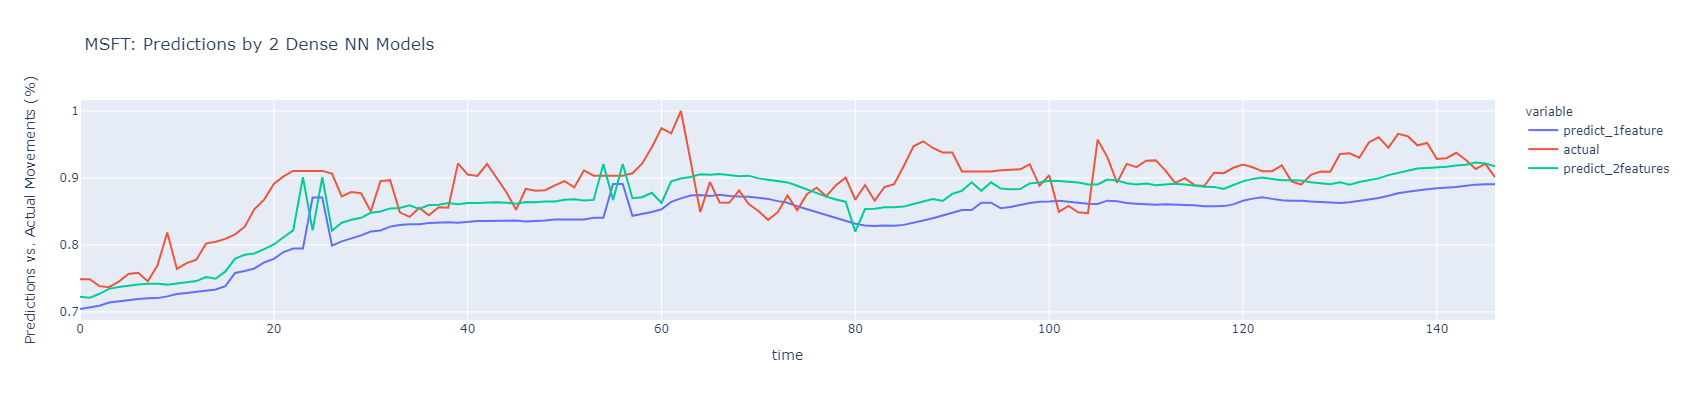

In [54]:
# plot predictions
msft_dense = plot_predictions_1fvs2f(pred_dense_1feature, pred_dense_2features, 'MSFT', 'Dense NN')
msft_dense

In [55]:
# plot loss
plot_loss_1fvs2f(score_lstm_1feature, score_lstm_2features, 'MSFT', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [56]:
# plot mae
plot_mae_1fvs2f(score_lstm_1feature, score_lstm_2features, 'MSFT', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

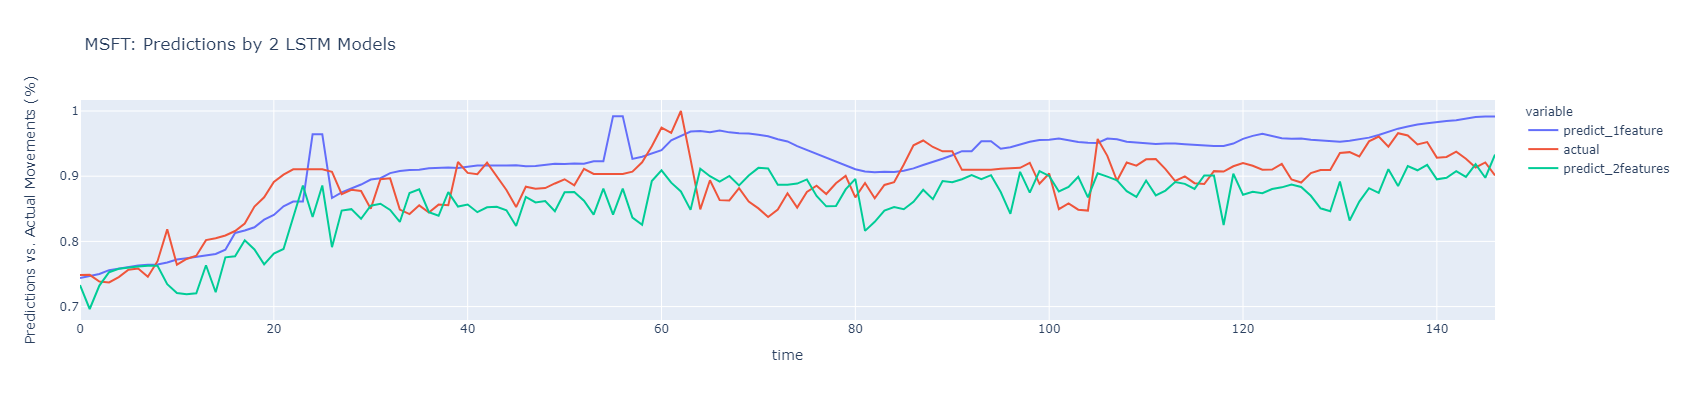

In [57]:
# plot predictions
msft_lstm = plot_predictions_1fvs2f(pred_lstm_1feature, pred_lstm_2features, 'MSFT', 'LSTM')
msft_lstm

### (3) Classification

##### Create a 1-feature dataset

In [58]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_classification(df_MSFT, "MSFT")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_1feature_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 1)
[[43.582  ]
 [43.501  ]
 [42.94275]
 [43.11525]
 [43.28825]]
(702, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


#### (a) Apply 1-Feature Dense NN

In [59]:
# call a function to apply a model
history, model = classification_dense_1feature(X_train, y_train)

# call a function to save scores
dic_dense_1feature = eva_classification_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-Feature LSTM 

In [60]:
# call a function to apply a model
history, model = classification_lstm_1feature(X_train, y_train)

# call a function to save scores
dic_lstm_1feature = eva_classification_lstm_1feature(model, X_test, y_test)

#### (c) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [61]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_1feature = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_1feature = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_1feature = svc_optimizer(X_train, y_train, X_test, y_test)

[13:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Create a 2-features dataset

(702, 2)
[[43.582    0.6705 ]
 [43.501    0.4019 ]
 [42.94275  0.     ]
 [43.11525  0.1901 ]
 [43.28825  0.     ]]
(702, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


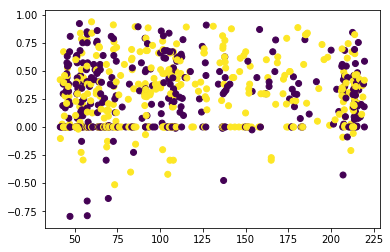

In [62]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_classification(df_MSFT, "MSFT")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_2features_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

# call a function to plot the data
plot_data(X, y)

#### (d) Apply 2-Features Dense NN

In [63]:
history, model = classification_dense_2features(X_train, y_train)
dic_dense_2features = eva_classification_dense_2features(model, X_test, y_test)

#### (e) Apply 2-Features LSTM

In [64]:
history, model = classification_lstm_2features(X_train, y_train)
dic_lstm_2features = eva_classification_lstm_2features(model, X_test, y_test)

#### (f) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [65]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_2features = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_2features = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_2features = svc_optimizer(X_train, y_train, X_test, y_test)

[13:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### (g) Scores between 1 Feature and 2 Features

In [66]:
# call a function to create a df
score_msft = create_score_dataframe(
                    dic_dense_1feature,
                    dic_lstm_1feature,
                    dic_sklearn_1feature,
                    dic_sklearn_crosval_1feature,
                    dic_svc_optimizer_1feature,
                    dic_dense_2features,
                    dic_lstm_2features,
                    dic_sklearn_2features,
                    dic_sklearn_crosval_2features,
                    dic_svc_optimizer_2features,
                    "MSFT"
                   )

score_msft

MSFT             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.531915   0.489362   
DecisionTreeClassifier (Cross Validation)  0.410385   0.403262   
Dense                                      0.531915   0.531915   
LSTM                                       0.531915   0.531915   
LogisticRegression                         0.531915   0.531915   
LogisticRegression (Cross Validation)      0.527072   0.535583   
RandomForestClassifier                     0.531915   0.503546   
RandomForestClassifier (Cross Validation)  0.410385   0.406069   
SVC                                        0.531915   0.531915   
SVC (Cross Validation)                     0.504377   0.515724   
SVC (Grid Search)                          0.531915   0.531915   
XGBClassifier                              0.468085   0.468085   
XGBClassifier (Cross Validation)           0.408956   0.398967   

                                                            
                                          sentiment_effect  
DecisionTreeClassifier                           -0.042553  
DecisionTreeClassifier (Cross Validation)        -0.007123  
Dense                                             0.000000  
LSTM                                              0.000000  
LogisticRegression                                0.000000  
LogisticRegression (Cross Validation)             0.008511  
RandomForestClassifier                           -0.028369  
RandomForestClassifier (Cross Validation)        -0.004316  
SVC                                               0.000000  
SVC (Cross Validation)                            0.011348  
SVC (Grid Search)                                 0.000000  
XGBClassifier                                     0.000000  
XGBClassifier (Cross Validation)                 -0.009990

## 2. SNE

### (1) Create a Dataframe

In [67]:
# call functions to create a sentiment dataframe and a stock dataframe and combine them
df = read_file("SNE")
df1 = sentiment_analysis(df)
df2 = stock_prices('SNE')
df3 = add_sma_signal(df2, 'SNE')
df_SNE = combine_dataframe(df3, df1, 'SNE')

print(f'The number of Tweets after screening: {len(df)}')
print(f'The number of data samples: {len(df_SNE)}')
display(df_SNE.head())

The number of Tweets after screening: 1240
The number of data samples: 545


SNE    SMA20  SMA_shift  daily_return  signal  sentiment
Date                                                                  
2015-02-13  27.30  24.1607    23.8427      0.006266     1.0       0.00
2015-02-27  28.33  26.4827    26.2447      0.007110     1.0       0.00
2015-03-16  25.83  27.3850    27.4585     -0.028217     0.0       0.00
2015-03-17  26.76  27.3935    27.3850      0.036005     1.0      -0.25
2015-03-18  28.12  27.3995    27.3935      0.050822     1.0       0.00

### (2) Regression

##### Create a 1-feature Dataset

In [68]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_regression(df_SNE, 'SNE')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(545, 1)
[[23.8427]
 [26.2447]
 [27.4585]
 [27.385 ]
 [27.3935]]
(545, 1)
[[27.3 ]
 [28.33]
 [25.83]
 [26.76]
 [28.12]]


#### (a) Apply 1-feature Dense NN

In [69]:
# call a function to apply a model
history, model = regression_dense_1feature(X_train, y_train)

# call a function to save scores
score_dense_1feature = score_regression_dense_1feature(history)

# call a function to make predictions
pred_dense_1feature = pred_regression_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-feature LSTM

In [70]:
# call a function to apply a model
history, model = regression_lstm_1feature(X_train, y_train)

# call a function to save scores
score_lstm_1feature = score_regression_lstm_1feature(history)

# call a function to make predictions
pred_lstm_1feature = pred_regression_lstm_1feature(model, X_test, y_test)

##### Create a 2-features Dataset

In [71]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_regression(df_SNE, 'SNE')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
display(X.head())
print(y.shape)
display(y.head())

(545, 2)


SMA_shift  sentiment
Date                            
2015-02-13    23.8427       0.00
2015-02-27    26.2447       0.00
2015-03-16    27.4585       0.00
2015-03-17    27.3850      -0.25
2015-03-18    27.3935       0.00

(545, 1)


SNE
Date             
2015-02-13  27.30
2015-02-27  28.33
2015-03-16  25.83
2015-03-17  26.76
2015-03-18  28.12

#### (c) Apply 2-features Dense NN

In [72]:
# call a function to apply a model
history, model = regression_dense_2features(X_train, y_train)

# call a function to save scores
score_dense_2features = score_regression_dense_2features(history)

# call a function to make predictions
pred_dense_2features = pred_regression_dense_2features(model, X_test, y_test)

#### (d) Apply 2-features LSTM

In [73]:
# call a function to apply a model
history, model = regression_lstm_2features(X_train, y_train)

# call a function to save scores
score_lstm_2features = score_regression_lstm_2features(history)

# call a function to make predictions
pred_lstm_2features = pred_regression_lstm_2features(model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [74]:
# plot loss
plot_loss_1fvs2f(score_dense_1feature, score_dense_2features, 'SNE', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [75]:
# plot mae
plot_mae_1fvs2f(score_dense_1feature, score_dense_2features, 'SNE', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

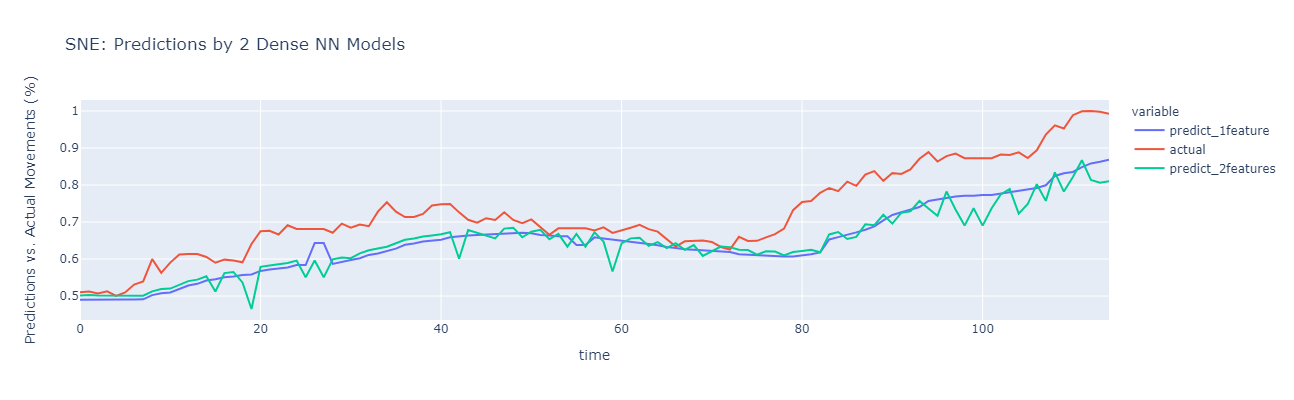

In [76]:
# plot predictions
sne_dense = plot_predictions_1fvs2f(pred_dense_1feature, pred_dense_2features, 'SNE', 'Dense NN')
sne_dense

In [77]:
# plot loss
plot_loss_1fvs2f(score_lstm_1feature, score_lstm_2features, 'SNE', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [78]:
# plot mae
plot_mae_1fvs2f(score_lstm_1feature, score_lstm_2features, 'SNE', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

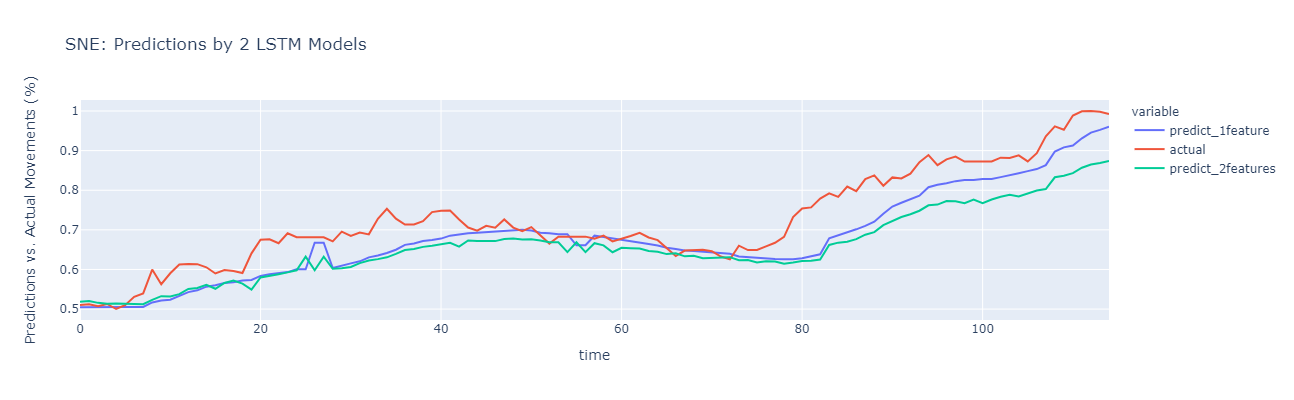

In [79]:
# plot predictions
sne_lstm = plot_predictions_1fvs2f(pred_lstm_1feature, pred_lstm_2features, 'SNE', 'LSTM')
sne_lstm

### (3) Classification

##### Create a 1-feature dataset

In [80]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_classification(df_SNE, "SNE")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_1feature_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(545, 1)
[[23.8427]
 [26.2447]
 [27.4585]
 [27.385 ]
 [27.3935]]
(545, 1)
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]


#### (a) Apply 1-Feature Dense NN

In [81]:
# call a function to apply a model
history, model = classification_dense_1feature(X_train, y_train)

# call a function to save scores
dic_dense_1feature = eva_classification_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-Feature LSTM 

In [82]:
# call a function to apply a model
history, model = classification_lstm_1feature(X_train, y_train)

# call a function to save scores
dic_lstm_1feature = eva_classification_lstm_1feature(model, X_test, y_test)

#### (c) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [83]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_1feature = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_1feature = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_1feature = svc_optimizer(X_train, y_train, X_test, y_test)

[13:35:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Create a 2-features dataset

(545, 2)
[[23.8427  0.    ]
 [26.2447  0.    ]
 [27.4585  0.    ]
 [27.385  -0.25  ]
 [27.3935  0.    ]]
(545, 1)
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]


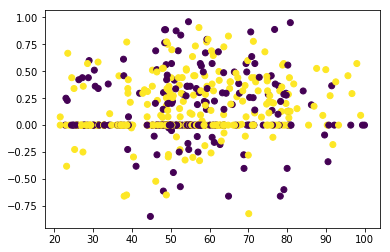

In [84]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_classification(df_SNE, "SNE")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_2features_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

# call a function to plot the data
plot_data(X, y)

#### (d) Apply 2-Features Dense NN

In [85]:
history, model = classification_dense_2features(X_train, y_train)
dic_dense_2features = eva_classification_dense_2features(model, X_test, y_test)

#### (e) Apply 2-Features LSTM

In [86]:
history, model = classification_lstm_2features(X_train, y_train)
dic_lstm_2features = eva_classification_lstm_2features(model, X_test, y_test)

#### (f) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [87]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_2features = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_2features = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_2features = svc_optimizer(X_train, y_train, X_test, y_test)

[13:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### (g) Scores between 1 Feature and 2 Features

In [88]:
# call a function to create a df
score_sne = create_score_dataframe(
                    dic_dense_1feature,
                    dic_lstm_1feature,
                    dic_sklearn_1feature,
                    dic_sklearn_crosval_1feature,
                    dic_svc_optimizer_1feature,
                    dic_dense_2features,
                    dic_lstm_2features,
                    dic_sklearn_2features,
                    dic_sklearn_crosval_2features,
                    dic_svc_optimizer_2features,
                    "SNE"
                   )

score_sne

SNE             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.458716   0.559633   
DecisionTreeClassifier (Cross Validation)  0.445872   0.478899   
Dense                                      0.605505   0.605505   
LSTM                                       0.605505   0.605505   
LogisticRegression                         0.605505   0.596330   
LogisticRegression (Cross Validation)      0.563303   0.563303   
RandomForestClassifier                     0.458716   0.522936   
RandomForestClassifier (Cross Validation)  0.445872   0.517431   
SVC                                        0.605505   0.633028   
SVC (Cross Validation)                     0.563303   0.563303   
SVC (Grid Search)                          0.605505   0.605505   
XGBClassifier                              0.440367   0.522936   
XGBClassifier (Cross Validation)           0.462385   0.477064   

                                                            
                                          sentiment_effect  
DecisionTreeClassifier                            0.100917  
DecisionTreeClassifier (Cross Validation)         0.033028  
Dense                                             0.000000  
LSTM                                              0.000000  
LogisticRegression                               -0.009174  
LogisticRegression (Cross Validation)             0.000000  
RandomForestClassifier                            0.064220  
RandomForestClassifier (Cross Validation)         0.071560  
SVC                                               0.027523  
SVC (Cross Validation)                            0.000000  
SVC (Grid Search)                                 0.000000  
XGBClassifier                                     0.082569  
XGBClassifier (Cross Validation)                  0.014679

## 3. PFE

### (1) Create a Dataframe

In [89]:
# call functions to create a sentiment dataframe and a stock dataframe and combine them
df = read_file("PFE")
df1 = sentiment_analysis(df)
df2 = stock_prices('PFE')
df3 = add_sma_signal(df2, 'PFE')
df_PFE = combine_dataframe(df3, df1, 'PFE')

print(f'The number of Tweets after screening: {len(df)}')
print(f'The number of data samples: {len(df_PFE)}')
display(df_PFE.head())

The number of Tweets after screening: 1530
The number of data samples: 738


PFE     SMA20  SMA_shift  daily_return  signal  sentiment
Date                                                                    
2015-02-13  34.640  32.85850    32.7465     -0.006596     0.0    0.00000
2015-02-19  34.410  33.10300    33.0155     -0.001451     0.0   -0.59940
2015-02-23  34.380  33.28700    33.1905     -0.004920     0.0    0.00000
2015-03-03  34.570  34.04200    33.8960     -0.005466     0.0    0.07415
2015-03-11  33.665  34.39825    34.4220     -0.003994     0.0    0.31820

### (2) Regression

##### Create a 1-feature Dataset

In [90]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_regression(df_PFE, 'PFE')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(738, 1)
[[32.7465]
 [33.0155]
 [33.1905]
 [33.896 ]
 [34.422 ]]
(738, 1)
[[34.64 ]
 [34.41 ]
 [34.38 ]
 [34.57 ]
 [33.665]]


#### (a) Apply 1-feature Dense NN

In [91]:
# call a function to apply a model
history, model = regression_dense_1feature(X_train, y_train)

# call a function to save scores
score_dense_1feature = score_regression_dense_1feature(history)

# call a function to make predictions
pred_dense_1feature = pred_regression_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-feature LSTM

In [92]:
# call a function to apply a model
history, model = regression_lstm_1feature(X_train, y_train)

# call a function to save scores
score_lstm_1feature = score_regression_lstm_1feature(history)

# call a function to make predictions
pred_lstm_1feature = pred_regression_lstm_1feature(model, X_test, y_test)

##### Create a 2-features Dataset

In [93]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_regression(df_PFE, 'PFE')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
display(X.head())
print(y.shape)
display(y.head())

(738, 2)


SMA_shift  sentiment
Date                            
2015-02-13    32.7465    0.00000
2015-02-19    33.0155   -0.59940
2015-02-23    33.1905    0.00000
2015-03-03    33.8960    0.07415
2015-03-11    34.4220    0.31820

(738, 1)


PFE
Date              
2015-02-13  34.640
2015-02-19  34.410
2015-02-23  34.380
2015-03-03  34.570
2015-03-11  33.665

#### (c) Apply 2-features Dense NN

In [94]:
# call a function to apply a model
history, model = regression_dense_2features(X_train, y_train)

# call a function to save scores
score_dense_2features = score_regression_dense_2features(history)

# call a function to make predictions
pred_dense_2features = pred_regression_dense_2features(model, X_test, y_test)

#### (d) Apply 2-features LSTM

In [95]:
# call a function to apply a model
history, model = regression_lstm_2features(X_train, y_train)

# call a function to save scores
score_lstm_2features = score_regression_lstm_2features(history)

# call a function to make predictions
pred_lstm_2features = pred_regression_lstm_2features(model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [96]:
# plot loss
plot_loss_1fvs2f(score_dense_1feature, score_dense_2features, 'PFE', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [97]:
# plot mae
plot_mae_1fvs2f(score_dense_1feature, score_dense_2features, 'PFE', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

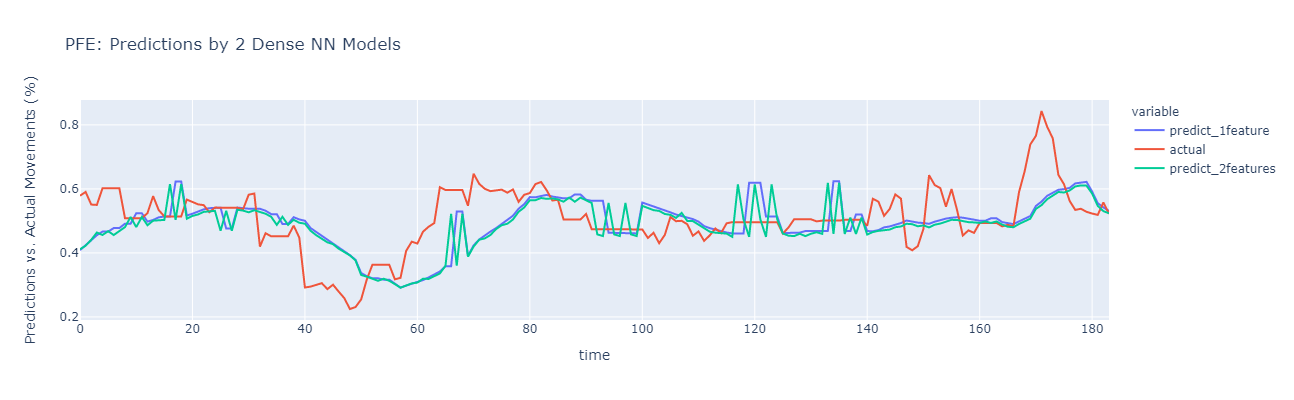

In [98]:
# plot predictions
pfe_dense = plot_predictions_1fvs2f(pred_dense_1feature, pred_dense_2features, 'PFE', 'Dense NN')
pfe_dense

In [99]:
# plot loss
plot_loss_1fvs2f(score_lstm_1feature, score_lstm_2features, 'PFE', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [100]:
# plot mae
plot_mae_1fvs2f(score_lstm_1feature, score_lstm_2features, 'PFE', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

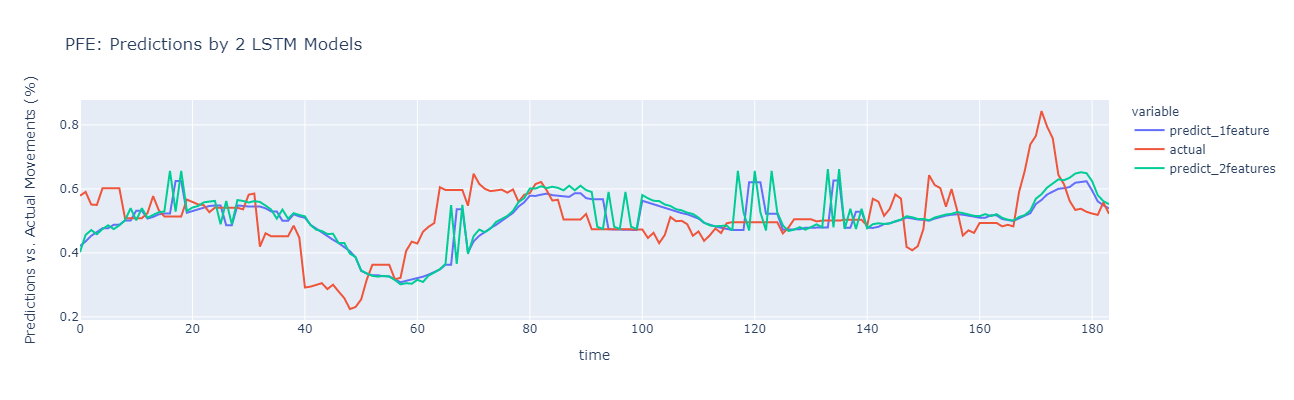

In [101]:
# plot predictions
pfe_lstm = plot_predictions_1fvs2f(pred_lstm_1feature, pred_lstm_2features, 'PFE', 'LSTM')
pfe_lstm

### (3) Classification

##### Create a 1-feature dataset

In [102]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_classification(df_PFE, "PFE")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_1feature_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(738, 1)
[[32.7465]
 [33.0155]
 [33.1905]
 [33.896 ]
 [34.422 ]]
(738, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


#### (a) Apply 1-Feature Dense NN

In [103]:
# call a function to apply a model
history, model = classification_dense_1feature(X_train, y_train)

# call a function to save scores
dic_dense_1feature = eva_classification_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-Feature LSTM 

In [104]:
# call a function to apply a model
history, model = classification_lstm_1feature(X_train, y_train)

# call a function to save scores
dic_lstm_1feature = eva_classification_lstm_1feature(model, X_test, y_test)

#### (c) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [105]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_1feature = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_1feature = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_1feature = svc_optimizer(X_train, y_train, X_test, y_test)

[13:37:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Create a 2-features dataset

(738, 2)
[[32.7465   0.     ]
 [33.0155  -0.5994 ]
 [33.1905   0.     ]
 [33.896    0.07415]
 [34.422    0.3182 ]]
(738, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


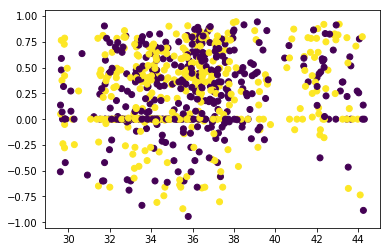

In [106]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_classification(df_PFE, "PFE")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_2features_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

# call a function to plot the data
plot_data(X, y)

#### (d) Apply 2-Features Dense NN

In [107]:
history, model = classification_dense_2features(X_train, y_train)
dic_dense_2features = eva_classification_dense_2features(model, X_test, y_test)

#### (e) Apply 2-Features LSTM

In [108]:
history, model = classification_lstm_2features(X_train, y_train)
dic_lstm_2features = eva_classification_lstm_2features(model, X_test, y_test)

#### (f) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [109]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_2features = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_2features = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_2features = svc_optimizer(X_train, y_train, X_test, y_test)

[13:37:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### (g) Scores between 1 Feature and 2 Features

In [110]:
# call a function to create a df
score_pfe = create_score_dataframe(
                    dic_dense_1feature,
                    dic_lstm_1feature,
                    dic_sklearn_1feature,
                    dic_sklearn_crosval_1feature,
                    dic_svc_optimizer_1feature,
                    dic_dense_2features,
                    dic_lstm_2features,
                    dic_sklearn_2features,
                    dic_sklearn_crosval_2features,
                    dic_svc_optimizer_2features,
                    "PFE"
                   )

score_pfe

PFE             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.500000   0.527027   
DecisionTreeClassifier (Cross Validation)  0.485172   0.500101   
Dense                                      0.432432   0.385135   
LSTM                                       0.425676   0.432432   
LogisticRegression                         0.385135   0.412162   
LogisticRegression (Cross Validation)      0.487764   0.483719   
RandomForestClassifier                     0.500000   0.506757   
RandomForestClassifier (Cross Validation)  0.485172   0.493326   
SVC                                        0.567568   0.554054   
SVC (Cross Validation)                     0.476990   0.509487   
SVC (Grid Search)                          0.391892   0.412162   
XGBClassifier                              0.513514   0.472973   
XGBClassifier (Cross Validation)           0.475639   0.498787   

                                                            
                                          sentiment_effect  
DecisionTreeClassifier                            0.027027  
DecisionTreeClassifier (Cross Validation)         0.014929  
Dense                                            -0.047297  
LSTM                                              0.006757  
LogisticRegression                                0.027027  
LogisticRegression (Cross Validation)            -0.004045  
RandomForestClassifier                            0.006757  
RandomForestClassifier (Cross Validation)         0.008154  
SVC                                              -0.013514  
SVC (Cross Validation)                            0.032497  
SVC (Grid Search)                                 0.020270  
XGBClassifier                                    -0.040541  
XGBClassifier (Cross Validation)                  0.023148

## 4. REGN

### (1) Create a Dataframe

In [111]:
# call functions to create a sentiment dataframe and a stock dataframe and combine them
df = read_file("REGN")
df1 = sentiment_analysis(df)
df2 = stock_prices('REGN')
df3 = add_sma_signal(df2, 'REGN')
df_REGN = combine_dataframe(df3, df1, 'REGN')
df_REGN.dropna(inplace=True)

print(f'The number of Tweets after screening: {len(df)}')
print(f'The number of data samples: {len(df_REGN)}')
display(df_REGN.head())

The number of Tweets after screening: 1001
The number of data samples: 612


REGN      SMA20  SMA_shift  daily_return  signal  sentiment
Date                                                                     
2015-02-13  402.40  410.73675  410.47325      0.001618     1.0    0.56905
2015-02-20  423.82  410.33725  410.18725     -0.006307     0.0    0.00000
2015-03-05  429.04  412.98250  411.59350      0.038662     1.0    0.81220
2015-03-06  422.19  413.40050  412.98250     -0.015966     0.0    0.00000
2015-03-17  467.84  425.09900  421.91750      0.035571     1.0    0.57190

### (2) Regression

##### Create a 1-feature Dataset

In [112]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_regression(df_REGN, 'REGN')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(612, 1)
[[410.47325]
 [410.18725]
 [411.5935 ]
 [412.9825 ]
 [421.9175 ]]
(612, 1)
[[402.4 ]
 [423.82]
 [429.04]
 [422.19]
 [467.84]]


#### (a) Apply 1-feature Dense NN

In [113]:
# call a function to apply a model
history, model = regression_dense_1feature(X_train, y_train)

# call a function to save scores
score_dense_1feature = score_regression_dense_1feature(history)

# call a function to make predictions
pred_dense_1feature = pred_regression_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-feature LSTM

In [114]:
# call a function to apply a model
history, model = regression_lstm_1feature(X_train, y_train)

# call a function to save scores
score_lstm_1feature = score_regression_lstm_1feature(history)

# call a function to make predictions
pred_lstm_1feature = pred_regression_lstm_1feature(model, X_test, y_test)

##### Create a 2-features Dataset

In [115]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_regression(df_REGN, 'REGN')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
display(X.head())
print(y.shape)
display(y.head())

(612, 2)


SMA_shift  sentiment
Date                            
2015-02-13  410.47325    0.56905
2015-02-20  410.18725    0.00000
2015-03-05  411.59350    0.81220
2015-03-06  412.98250    0.00000
2015-03-17  421.91750    0.57190

(612, 1)


REGN
Date              
2015-02-13  402.40
2015-02-20  423.82
2015-03-05  429.04
2015-03-06  422.19
2015-03-17  467.84

#### (c) Apply 2-features Dense NN

In [116]:
# call a function to apply a model
history, model = regression_dense_2features(X_train, y_train)

# call a function to save scores
score_dense_2features = score_regression_dense_2features(history)

# call a function to make predictions
pred_dense_2features = pred_regression_dense_2features(model, X_test, y_test)

#### (d) Apply 2-features LSTM

In [117]:
# call a function to apply a model
history, model = regression_lstm_2features(X_train, y_train)

# call a function to save scores
score_lstm_2features = score_regression_lstm_2features(history)

# call a function to make predictions
pred_lstm_2features = pred_regression_lstm_2features(model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [118]:
# plot loss
plot_loss_1fvs2f(score_dense_1feature, score_dense_2features, 'REGN', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [119]:
# plot mae
plot_mae_1fvs2f(score_dense_1feature, score_dense_2features, 'REGN', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

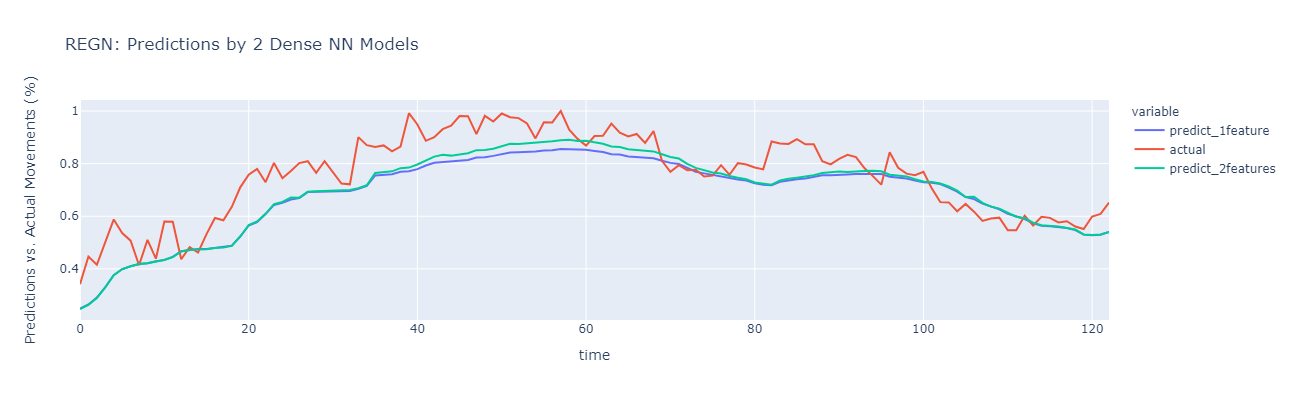

In [120]:
# plot predictions
regn_dense = plot_predictions_1fvs2f(pred_dense_1feature, pred_dense_2features, 'REGN', 'Dense NN')
regn_dense

In [121]:
# plot loss
plot_loss_1fvs2f(score_lstm_1feature, score_lstm_2features, 'REGN', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [122]:
# plot mae
plot_mae_1fvs2f(score_lstm_1feature, score_lstm_2features, 'REGN', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

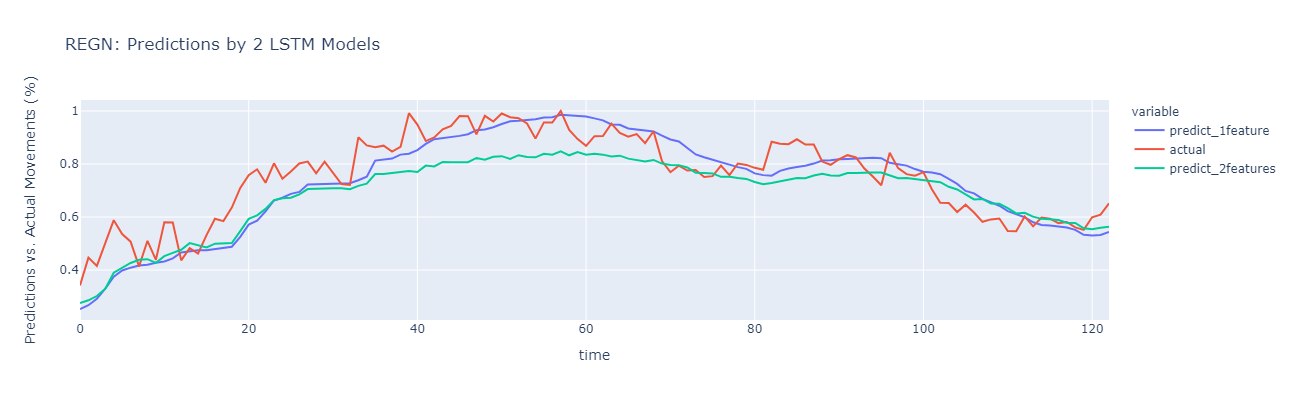

In [123]:
# plot predictions
regn_lstm = plot_predictions_1fvs2f(pred_lstm_1feature, pred_lstm_2features, 'REGN', 'LSTM')
regn_lstm

### (3) Classification

##### Create a 1-feature dataset

In [124]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_classification(df_REGN, "REGN")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_1feature_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(612, 1)
[[410.47325]
 [410.18725]
 [411.5935 ]
 [412.9825 ]
 [421.9175 ]]
(612, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


#### (a) Apply 1-Feature Dense NN

In [125]:
# call a function to apply a model
history, model = classification_dense_1feature(X_train, y_train)

# call a function to save scores
dic_dense_1feature = eva_classification_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-Feature LSTM 

In [126]:
# call a function to apply a model
history, model = classification_lstm_1feature(X_train, y_train)

# call a function to save scores
dic_lstm_1feature = eva_classification_lstm_1feature(model, X_test, y_test)

#### (c) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [127]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_1feature = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_1feature = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_1feature = svc_optimizer(X_train, y_train, X_test, y_test)

[13:38:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Create a 2-features dataset

(612, 2)
[[410.47325   0.56905]
 [410.18725   0.     ]
 [411.5935    0.8122 ]
 [412.9825    0.     ]
 [421.9175    0.5719 ]]
(612, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


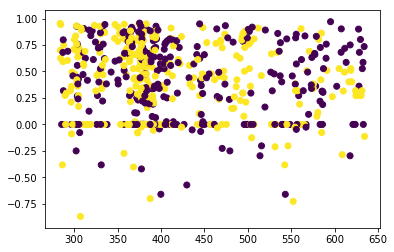

In [128]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_classification(df_REGN, "REGN")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_2features_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

# call a function to plot the data
plot_data(X, y)

#### (d) Apply 2-Features Dense NN

In [129]:
history, model = classification_dense_2features(X_train, y_train)
dic_dense_2features = eva_classification_dense_2features(model, X_test, y_test)

#### (e) Apply 2-Features LSTM

In [130]:
history, model = classification_lstm_2features(X_train, y_train)
dic_lstm_2features = eva_classification_lstm_2features(model, X_test, y_test)

#### (f) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [131]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_2features = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_2features = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_2features = svc_optimizer(X_train, y_train, X_test, y_test)

[13:38:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:38:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### (g) Scores between 1 Feature and 2 Features

In [132]:
# call a function to create a df
score_regn = create_score_dataframe(
                    dic_dense_1feature,
                    dic_lstm_1feature,
                    dic_sklearn_1feature,
                    dic_sklearn_crosval_1feature,
                    dic_svc_optimizer_1feature,
                    dic_dense_2features,
                    dic_lstm_2features,
                    dic_sklearn_2features,
                    dic_sklearn_crosval_2features,
                    dic_svc_optimizer_2features,
                    "REGN"
                   )

score_regn

REGN             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.552846   0.560976   
DecisionTreeClassifier (Cross Validation)  0.519512   0.553778   
Dense                                      0.520325   0.520325   
LSTM                                       0.528455   0.528455   
LogisticRegression                         0.520325   0.528455   
LogisticRegression (Cross Validation)      0.522844   0.516340   
RandomForestClassifier                     0.552846   0.601626   
RandomForestClassifier (Cross Validation)  0.519512   0.570145   
SVC                                        0.569106   0.552846   
SVC (Cross Validation)                     0.518046   0.514714   
SVC (Grid Search)                          0.479675   0.479675   
XGBClassifier                              0.528455   0.528455   
XGBClassifier (Cross Validation)           0.548874   0.540717   

                                                            
                                          sentiment_effect  
DecisionTreeClassifier                            0.008130  
DecisionTreeClassifier (Cross Validation)         0.034266  
Dense                                             0.000000  
LSTM                                              0.000000  
LogisticRegression                                0.008130  
LogisticRegression (Cross Validation)            -0.006504  
RandomForestClassifier                            0.048780  
RandomForestClassifier (Cross Validation)         0.050633  
SVC                                              -0.016260  
SVC (Cross Validation)                           -0.003332  
SVC (Grid Search)                                 0.000000  
XGBClassifier                                     0.000000  
XGBClassifier (Cross Validation)                 -0.008157

## 5. MRNA

### (1) Create a Dataframe

In [133]:
# call functions to create a sentiment dataframe and a stock dataframe and combine them
df = read_file("MRNA")
df1 = sentiment_analysis(df)
df2 = stock_prices('MRNA')
df3 = add_sma_signal(df2, 'MRNA')
df_MRNA = combine_dataframe(df3, df1, 'MRNA')

print(f'The number of Tweets after screening: {len(df)}')
print(f'The number of data samples: {len(df_MRNA)}')
display(df_MRNA.head())

The number of Tweets after screening: 103
The number of data samples: 61


MRNA      SMA20  SMA_shift  daily_return  signal  sentiment
Date                                                                    
2016-09-13   0.14   0.133448   0.132948      0.037037     1.0     0.2960
2020-03-04  27.46  22.428955  22.099455     -0.016123     0.0     0.0000
2020-03-16  26.44  24.060460  23.688460      0.241315     1.0     0.3182
2020-03-27  30.05  26.826510  26.621510      0.076289     1.0     0.0000
2020-04-14  34.65  30.502000  30.091500      0.053512     1.0     0.3182

### (2) Regression

##### Create a 1-feature Dataset

In [134]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_regression(df_MRNA, 'MRNA')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_1feature_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(61, 1)
[[ 0.1329475]
 [22.099455 ]
 [23.68846  ]
 [26.62151  ]
 [30.0915   ]]
(61, 1)
[[ 0.14]
 [27.46]
 [26.44]
 [30.05]
 [34.65]]


#### (a) Apply 1-feature Dense NN

In [135]:
# call a function to apply a model
history, model = regression_dense_1feature(X_train, y_train)

# call a function to save scores
score_dense_1feature = score_regression_dense_1feature(history)

# call a function to make predictions
pred_dense_1feature = pred_regression_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-feature LSTM

In [136]:
# call a function to apply a model
history, model = regression_lstm_1feature(X_train, y_train)

# call a function to save scores
score_lstm_1feature = score_regression_lstm_1feature(history)

# call a function to make predictions
pred_lstm_1feature = pred_regression_lstm_1feature(model, X_test, y_test)

##### Create a 2-features Dataset

In [137]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_regression(df_MRNA, 'MRNA')

# call a function to scale the dataset
X, X_train, X_test, y, y_train, y_test = scaler_for_2features_regression_data(X, X_train, X_test, y, y_train, y_test)

# check the data created
print(X.shape)
display(X.head())
print(y.shape)
display(y.head())

(61, 2)


SMA_shift  sentiment
Date                            
2016-09-13   0.132948     0.2960
2020-03-04  22.099455     0.0000
2020-03-16  23.688460     0.3182
2020-03-27  26.621510     0.0000
2020-04-14  30.091500     0.3182

(61, 1)


MRNA
Date             
2016-09-13   0.14
2020-03-04  27.46
2020-03-16  26.44
2020-03-27  30.05
2020-04-14  34.65

#### (c) Apply 2-features Dense NN

In [138]:
# call a function to apply a model
history, model = regression_dense_2features(X_train, y_train)

# call a function to save scores
score_dense_2features = score_regression_dense_2features(history)

# call a function to make predictions
pred_dense_2features = pred_regression_dense_2features(model, X_test, y_test)

#### (d) Apply 2-features LSTM

In [139]:
# call a function to apply a model
history, model = regression_lstm_2features(X_train, y_train)

# call a function to save scores
score_lstm_2features = score_regression_lstm_2features(history)

# call a function to make predictions
pred_lstm_2features = pred_regression_lstm_2features(model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [140]:
# plot loss
plot_loss_1fvs2f(score_dense_1feature, score_dense_2features, 'MRNA', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [141]:
# plot mae
plot_mae_1fvs2f(score_dense_1feature, score_dense_2features, 'MRNA', 'Dense NN')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

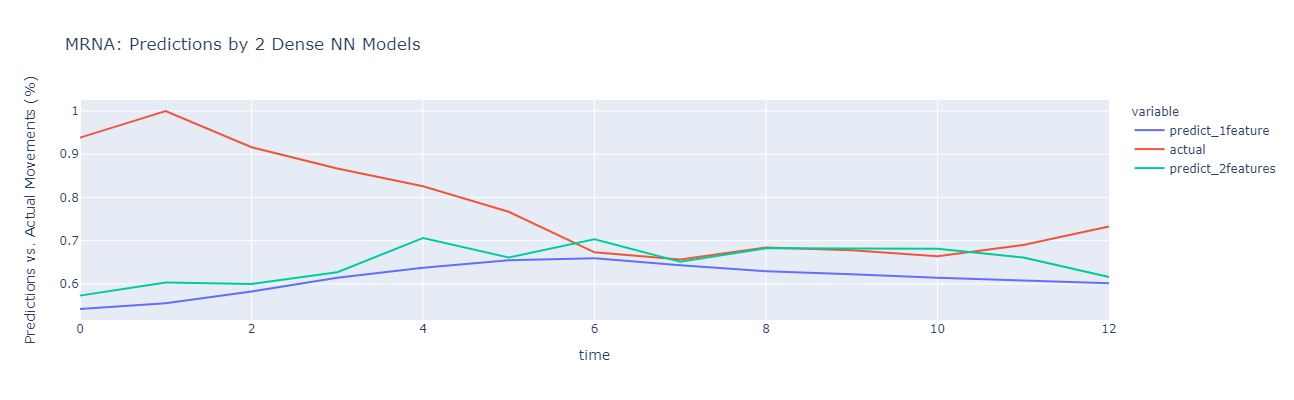

In [142]:
# plot predictions
mrna_dense = plot_predictions_1fvs2f(pred_dense_1feature, pred_dense_2features, 'MRNA', 'Dense NN')
mrna_dense

In [143]:
# plot loss
plot_loss_1fvs2f(score_lstm_1feature, score_lstm_2features, 'MRNA', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [144]:
# plot mae
plot_mae_1fvs2f(score_lstm_1feature, score_lstm_2features, 'MRNA', 'LSTM')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

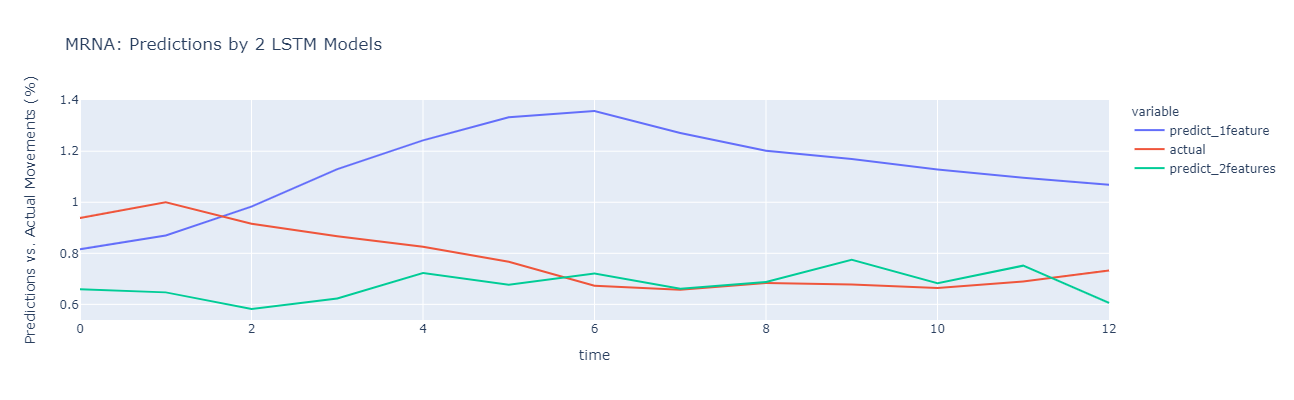

In [145]:
# plot predictions
mrna_lstm = plot_predictions_1fvs2f(pred_lstm_1feature, pred_lstm_2features, 'MRNA', 'LSTM')
mrna_lstm

### (3) Classification

##### Create a 1-feature dataset

In [146]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_1feature_classification(df_MRNA, "MRNA")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_1feature_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(61, 1)
[[ 0.1329475]
 [22.099455 ]
 [23.68846  ]
 [26.62151  ]
 [30.0915   ]]
(61, 1)
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


#### (a) Apply 1-Feature Dense NN

In [147]:
# call a function to apply a model
history, model = classification_dense_1feature(X_train, y_train)

# call a function to save scores
dic_dense_1feature = eva_classification_dense_1feature(model, X_test, y_test)

#### (b) Apply 1-Feature LSTM 

In [148]:
# call a function to apply a model
history, model = classification_lstm_1feature(X_train, y_train)

# call a function to save scores
dic_lstm_1feature = eva_classification_lstm_1feature(model, X_test, y_test)

#### (c) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [149]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_1feature = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_1feature = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_1feature = svc_optimizer(X_train, y_train, X_test, y_test)

[13:39:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

##### Create a 2-features dataset

(61, 2)
[[ 0.1329475  0.296    ]
 [22.099455   0.       ]
 [23.68846    0.3182   ]
 [26.62151    0.       ]
 [30.0915     0.3182   ]]
(61, 1)
[[1.]
 [0.]
 [1.]
 [1.]
 [1.]]


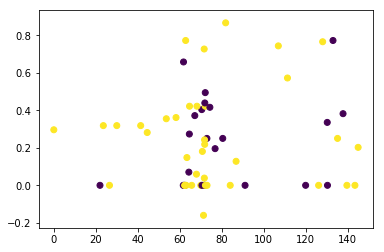

In [150]:
# call a function to create a dataset
X, X_train, X_test, y, y_train, y_test = create_dataset_for_2features_classification(df_MRNA, "MRNA")

# call a function to scale the dataset
X, X_train, X_test = scaler_for_2features_classification_data(X, X_train, X_test)

# check the data created
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

# call a function to plot the data
plot_data(X, y)

#### (d) Apply 2-Features Dense NN

In [151]:
history, model = classification_dense_2features(X_train, y_train)
dic_dense_2features = eva_classification_dense_2features(model, X_test, y_test)

#### (e) Apply 2-Features LSTM

In [152]:
history, model = classification_lstm_2features(X_train, y_train)
dic_lstm_2features = eva_classification_lstm_2features(model, X_test, y_test)

#### (f) Apply Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [153]:
# call the simple sklearn function to apply a model and save scores
dic_sklearn_2features = sklearn_classification(X_train, y_train, X_test, y_test)

# call the cross validation function to apply a model and save scores
dic_sklearn_crosval_2features = sklearn_classification_crosval(X, y)

# call the svc-optimizer function to apply a model and save scores
dic_svc_optimizer_2features = svc_optimizer(X_train, y_train, X_test, y_test)

[13:39:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### (g) Scores between 1 Feature and 2 Features

In [154]:
# call a function to create a df
score_mrna = create_score_dataframe(
                    dic_dense_1feature,
                    dic_lstm_1feature,
                    dic_sklearn_1feature,
                    dic_sklearn_crosval_1feature,
                    dic_svc_optimizer_1feature,
                    dic_dense_2features,
                    dic_lstm_2features,
                    dic_sklearn_2features,
                    dic_sklearn_crosval_2features,
                    dic_svc_optimizer_2features,
                    "MRNA"
                   )

score_mrna

MRNA             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.384615   0.384615   
DecisionTreeClassifier (Cross Validation)  0.488462   0.365385   
Dense                                      0.615385   0.615385   
LSTM                                       0.615385   0.615385   
LogisticRegression                         0.615385   0.615385   
LogisticRegression (Cross Validation)      0.606410   0.606410   
RandomForestClassifier                     0.384615   0.461538   
RandomForestClassifier (Cross Validation)  0.488462   0.315385   
SVC                                        0.615385   0.615385   
SVC (Cross Validation)                     0.639744   0.639744   
SVC (Grid Search)                          0.615385   0.461538   
XGBClassifier                              0.615385   0.615385   
XGBClassifier (Cross Validation)           0.488462   0.365385   

                                                            
                                          sentiment_effect  
DecisionTreeClassifier                            0.000000  
DecisionTreeClassifier (Cross Validation)        -0.123077  
Dense                                             0.000000  
LSTM                                              0.000000  
LogisticRegression                                0.000000  
LogisticRegression (Cross Validation)             0.000000  
RandomForestClassifier                            0.076923  
RandomForestClassifier (Cross Validation)        -0.173077  
SVC                                               0.000000  
SVC (Cross Validation)                            0.000000  
SVC (Grid Search)                                -0.153846  
XGBClassifier                                     0.000000  
XGBClassifier (Cross Validation)                 -0.123077

In [155]:
# call the function to combine all the 5 score dataframes
all_score_df = join_score_dataframe(score_msft, score_sne, score_pfe, score_regn, score_mrna)
all_score_df 

MSFT             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.531915   0.489362   
DecisionTreeClassifier (Cross Validation)  0.410385   0.403262   
Dense                                      0.531915   0.531915   
LSTM                                       0.531915   0.531915   
LogisticRegression                         0.531915   0.531915   
LogisticRegression (Cross Validation)      0.527072   0.535583   
RandomForestClassifier                     0.531915   0.503546   
RandomForestClassifier (Cross Validation)  0.410385   0.406069   
SVC                                        0.531915   0.531915   
SVC (Cross Validation)                     0.504377   0.515724   
SVC (Grid Search)                          0.531915   0.531915   
XGBClassifier                              0.468085   0.468085   
XGBClassifier (Cross Validation)           0.408956   0.398967   

                                                                 SNE  \
                                          sentiment_effect 1 Feature   
DecisionTreeClassifier                           -0.042553  0.458716   
DecisionTreeClassifier (Cross Validation)        -0.007123  0.445872   
Dense                                             0.000000  0.605505   
LSTM                                              0.000000  0.605505   
LogisticRegression                                0.000000  0.605505   
LogisticRegression (Cross Validation)             0.008511  0.563303   
RandomForestClassifier                           -0.028369  0.458716   
RandomForestClassifier (Cross Validation)        -0.004316  0.445872   
SVC                                               0.000000  0.605505   
SVC (Cross Validation)                            0.011348  0.563303   
SVC (Grid Search)                                 0.000000  0.605505   
XGBClassifier                                     0.000000  0.440367   
XGBClassifier (Cross Validation)                 -0.009990  0.462385   

                                                                       \
                                          2 Features sentiment_effect   
DecisionTreeClassifier                      0.559633         0.100917   
DecisionTreeClassifier (Cross Validation)   0.478899         0.033028   
Dense                                       0.605505         0.000000   
LSTM                                        0.605505         0.000000   
LogisticRegression                          0.596330        -0.009174   
LogisticRegression (Cross Validation)       0.563303         0.000000   
RandomForestClassifier                      0.522936         0.064220   
RandomForestClassifier (Cross Validation)   0.517431         0.071560   
SVC                                         0.633028         0.027523   
SVC (Cross Validation)                      0.563303         0.000000   
SVC (Grid Search)                           0.605505         0.000000   
XGBClassifier                               0.522936         0.082569   
XGBClassifier (Cross Validation)            0.477064         0.014679   

                                                PFE             \
                                          1 Feature 2 Features   
DecisionTreeClassifier                     0.500000   0.527027   
DecisionTreeClassifier (Cross Validation)  0.485172   0.500101   
Dense                                      0.432432   0.385135   
LSTM                                       0.425676   0.432432   
LogisticRegression                         0.385135   0.412162   
LogisticRegression (Cross Validation)      0.487764   0.483719   
RandomForestClassifier                     0.500000   0.506757   
RandomForestClassifier (Cross Validation)  0.485172   0.493326   
SVC                                        0.567568   0.554054   
SVC (Cross Validation)                     0.476990   0.509487   
SVC (Grid Search)                          0.391892   0.412162   
XGBClassifier        

# VI. Dashboard with Dash

In [156]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output

# Create a dashboard input using Dash applications
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets = [dbc.themes.BOOTSTRAP])

app.config.suppress_callback_exceptions = True

# Contain each visualization into each tab
regression_tab = dbc.Card(
                  dbc.CardBody([
                         dbc.Col([
                                  dbc.Row([
                                           dbc.Col(dcc.Graph(figure = msft_dense), width = 6),
                                           dbc.Col(dcc.Graph(figure = msft_lstm), width = 6)
                                         ]),
                                  dbc.Row([
                                           dbc.Col(dcc.Graph(figure = sne_dense), width = 6),
                                           dbc.Col(dcc.Graph(figure = sne_lstm), width = 6)
                                         ]),
                                  dbc.Row([
                                           dbc.Col(dcc.Graph(figure = pfe_dense), width = 6),
                                           dbc.Col(dcc.Graph(figure = pfe_lstm), width = 6)
                                         ]),
                                  dbc.Row([
                                           dbc.Col(dcc.Graph(figure = regn_dense), width = 6),
                                           dbc.Col(dcc.Graph(figure = regn_lstm), width = 6)
                                         ]),
                                  dbc.Row([
                                           dbc.Col(dcc.Graph(figure = mrna_dense), width = 6),
                                           dbc.Col(dcc.Graph(figure = mrna_lstm), width = 6)
                                         ])                     
                                 ])
                               ])
                         )

classification_tab = dbc.Card(
                  dbc.CardBody([
                        dbc.Col([dbc.Table.from_dataframe(all_score_df, striped=True, bordered=True, hover=True)])
                              ])
                             )

app.layout = html.Div([
                       dbc.Tabs([
                                 dbc.Tab(regression_tab, label = 'Regression', style = {"width": '2000px'}),
                                 dbc.Tab(classification_tab, label = 'Classification', style = {"width": '3000px'})
                                ],
                                style = {'float': 'left', 'width': 250, 'color': '#119DFF'}
                               )
                     ])

In [ ]:
if __name__ == '__main__':
    app.run_server(host = '127.0.0.1', port = 5000, debug = False)

Dash is running on http://127.0.0.1:5000/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Jan/2021 13:42:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Jan/2021 13:42:14] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/Jan/2021 13:42:14] "GET /_dash-layout HTTP/1.1" 200 -
